#### Imports

In [9]:
import os
from random import choices, choice
import random
from collections import defaultdict
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torch
import torch.nn as nn
from PIL import Image
from kekit.image import resize_image

#### Functions

In [13]:
def get_model(architecture='resnet34'):
    # input_shape: (3, 244, 244, 100)
    model = timm.create_model(architecture, pretrained=True)
    model.eval()
    return model

def get_embeddings(
    model, 
    img_paths, 
    layers=['layer3'],
    batch_size=300, 
    poolings=['max', 'mean'], 
    embs_sizes=[128, 256, 512]  # output embs size
) -> dict:
    # Computes embeddings for images from `img_paths` using `model`
    
    # The initial idea was to use PCA for dimensionality reduction after extracting all the embedings
    # But since number of dimensions is very high (especially for the lower layers e.g. 200k for the first one)
    # I used adaptive pooling instead, but had to handcraft the output size for each layer individually:

    # Layers go as follows (in this case adaptive pooling is configured to result in 512 output embeddings size):
    # layer1: torch.Size([bs, 64, 56, 56]) -> 200_704 || adapt_pool((2,4)) -> (bs, 64, 2, 4) -> flatten -> (bs, 512)
    # layer2: torch.Size([bs, 128, 28, 28]) -> 100_352 || adapt_pool((2,2)) -> (bs, 128, 2, 2) -> flatten -> (bs, 512)
    # layer3: torch.Size([bs, 256, 14, 14]) -> 50_176  || adapt_pool((2,1)) -> (bs, 256, 2, 1) -> flatten -> (bs, 512)
    # layer4: torch.Size([bs, 512, 7, 7]) -> 25_088  || adapt_pool((1,1)) -> (bs, 512, 1, 1) -> flatten -> (bs, 512)
    # global_pool: torch.Size([bs, 512]) -> 512 || nothing -> (bs, 512)
    
    # One may call the function for any combinations of layers and poolig types, everything will be saved into a resulting
    # dictionary with a key of (layer_name, embs_size, pooling_type)

    transform = create_transform(
        **resolve_data_config(model.pretrained_cfg, model=model)
    )

    # hook to get embeddings
    # refresh the container
    feature_store = defaultdict(torch.Tensor)
    pooling_types_ = poolings  # doesn't work otherwise lol
    embs_sizes_ = embs_sizes
    
    def get_features(layer_name):
        def hook(model, input, output):
            for pooling_type_ in pooling_types_:
                for embs_size_ in embs_sizes_:
                    output_ = output.clone()

                    if pooling_type_ == 'max':
                        pooling_cls = nn.AdaptiveMaxPool2d
                    elif pooling_type_ == 'mean':
                        pooling_cls = nn.AdaptiveAvgPool2d
                    else:
                        raise ValueError(f'wtf is {pooling_type} pooling?')

                    bs = output.shape[0]

                    if embs_size_ == 512:
                        pooling_sizes = [(2, 4), (2, 2), (2, 1), (1, 1)]
                    elif embs_size_ == 256:
                        pooling_sizes = [(2, 2), (2, 1), (1, 1), (1, 1)]
                    elif embs_size_ == 128:
                        pooling_sizes = [(2, 1), (1, 1), (1, 1), (1, 1)]
                    else:
                        raise ValueError('Unsupported embs_size')

                    if layer_name == 'layer1':
                        pooling = pooling_cls(pooling_sizes[0])
                        output_ = pooling(output_)
                    elif layer_name == 'layer2':
                        pooling = pooling_cls(pooling_sizes[1])
                        output_ = pooling(output_)
                    elif layer_name == 'layer3':
                        pooling = pooling_cls(pooling_sizes[2])
                        output_ = pooling(output_)
                    elif layer_name == 'layer4':
                        pooling = pooling_cls(pooling_sizes[3]) 
                        output_ = pooling(output_)
                    elif layer_name == 'global_pool':
                        pass
                    else:
                        raise ValueError(f'wtf is layer {layer_name}')

                    output_ = output_.reshape(output_.shape[0], -1)
                    pool_1d = nn.AdaptiveAvgPool1d(embs_size_)
                    output_ = pool_1d(output_)

                    output_ = output_.detach()

                    assert list(output_.shape) == [bs, embs_size_]

                    output_ = torch.cat([feature_store[layer_name], output_], axis=0)
                    feature_store[(layer_name, embs_size_, pooling_type_)] = output_
        return hook
    
    hooks = []
    for layer_name in layers:
        hook_func = get_features(layer_name)
        hook = model.__getattr__(layer_name).register_forward_hook(hook_func)
        hooks.append(hook)
    
    # inference
    print('Inferencing..')
    batch = []
    processed_paths = []
    for i, img_path in tqdm(enumerate(img_paths)):
        img = Image.open(img_path)
        if img.mode == "L":
            # greyscale image, skip..
            continue
        processed_paths.append(img_path)
        tenzor = transform(img).unsqueeze(0)
        batch.append(tenzor)
        if i % batch_size == 0 and i != 0:
            tenzors = torch.cat(batch, axis=0)
            _ = model(tenzors)
            batch = []

    # last batch problem
    if len(batch) > 0:
        tenzors = torch.cat(batch, axis=0)
        _ = model(tenzors)
        
    for hook in hooks:
        hook.remove()

    return feature_store


def get_topk_closest_indices(doc_embs, query_embs, k):
    # Compute the dot product
    doc_embs, query_embs = torch.Tensor(doc_embs), torch.Tensor(query_embs)
    dot_product = doc_embs @ query_embs.T

    # Compute the norms of the query and document matrices
    doc_norms = torch.norm(doc_embs, dim=1, keepdim=True)
    query_norms = torch.norm(query_embs, dim=1, keepdim=True)
    
    # Compute the pairwise cosine similarity
    cosine_similarity = dot_product / (query_norms @ doc_norms.T).T
    index = cosine_similarity.numpy()

    # Get topk docs' indices for each query
    closest_indices = np.argsort(index, axis=0)
    closest_indices = np.flip(closest_indices)
    closest_indices = closest_indices[:k]

    return closest_indices


def get_top_closest_different_layers(
    query_img_paths, 
    doc_img_paths,
    layers=['layer4', 'global_pool'],
    k=50,
    pooling_types=['max', 'mean'],
    embs_sizes=[128, 256, 512],
    batch_size=300,
    model_architecture='resnet34'
) -> dict:
    # For every image from `query_img_pahts` finds and returns indices of top `k` closest images from `doc_img_paths`.
    # `layers` - what layers of the model to use to extract embeddings for comparison
    # `pooling_types` - how to reduct dimensions of the embeddings (using max pooling vs mean pooling)
    # `embs_sizes` - what output embedding sizes to use (default values are the only supported)
    # returns a dict with keys (layer_name, embs_size, pooling_type) and values - indices of top doc images using these params
    
    model = get_model(architecture=model_architecture)
    
    # Get embeddings for queries and docs
    query_embs_dict = get_embeddings(
        model, 
        query_img_paths, 
        layers, 
        poolings=pooling_types, 
        embs_sizes=embs_sizes,
        batch_size=batch_size
    )
    doc_embs_dict = get_embeddings(
        model, 
        doc_img_paths, 
        layers, 
        poolings=pooling_types, 
        embs_sizes=embs_sizes,
        batch_size=batch_size
    )
    
    print('building index..')
    res = {}
    for layer in tqdm(layers):
        for embs_size in embs_sizes:
            for pooling_type in pooling_types:
                query_embs = query_embs_dict[(layer, embs_size, pooling_type)]
                doc_embs = doc_embs_dict[(layer, embs_size, pooling_type)]

                closest_indices = get_topk_closest_indices(
                    query_embs=query_embs, 
                    doc_embs=doc_embs,
                    k=k
                )

                res[(layer, embs_size, pooling_type)] = closest_indices

    return res

#### Action

In [7]:
# Load image paths
query_img_paths = [] # dresses' images
for file in os.listdir('../test_images/query'):
    query_fpath = os.path.join('../test_images/query', file)
    query_img_paths.append(query_fpath)
    
doc_img_paths = []  # dildos' images
for root, dirs, files in os.walk('../test_images/doc'):
    for file in files:
        doc_fpath = os.path.join(root, file)
        if os.path.isfile(doc_fpath):
            doc_img_paths.append(doc_fpath)

In [10]:
# sample docs if needed:
doc_img_paths = random.sample(doc_img_paths, 1000)

In [ ]:
closest_indices = get_top_closest_different_layers(
    query_img_paths=query_img_paths, 
    doc_img_paths=doc_img_paths, 
    layers=['layer1', 'layer2', 'layer3', 'layer4', 'global_pool'], 
    pooling_types=['mean', 'max'],
    embs_sizes=[128, 256, 512],
    k=500,tel
    batch_size=500
)

In [15]:
def draw_example(
    query_img_paths, 
    doc_img_paths, 
    closest_indices,
    topk=10,
    layer='layer1',
    embs_size=256,
    pooling='mean',
    figsize=(16, 12)
):
    closest_indices = closest_indices[(layer, embs_size, pooling)]

    rows = len(query_img_paths)
    cols = topk + 1
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for query_index in range(len(query_img_paths)):
        ax = axes[query_index]

        query_path = query_img_paths[query_index]
        query_img = Image.open(query_path)
        # query_img.thumbnail((300, 300), Image.Resampling.LANCZOS)
        query_img = query_img.resize((300, 300))

        closest_doc_idices = closest_indices[:, query_index]
        closest_doc_paths = [doc_img_paths[i] for i in closest_doc_idices]
        closest_doc_paths = closest_doc_paths[:10]
        ax[0].imshow(query_img)
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        for doc_index, doc_path in enumerate(closest_doc_paths):
            doc_img = Image.open(doc_path)
            # doc_img.thumbnail((200, 200), Image.Resampling.LANCZOS)
            doc_img = doc_img.resize((300, 300))
            ax[doc_index + 1].imshow(doc_img)
            ax[doc_index + 1].set_xticks([])
            ax[doc_index + 1].set_yticks([])
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    fig.tight_layout()
    plt.show()
    

def draw_all_layers(
    query_img_path, 
    doc_img_paths,
    query_index,
    closest_indices,
    topk=10,
    embs_size=256,
    pooling='mean',
    figsize=(16, 12)
):
    
    # print the query
    query_img = Image.open(query_img_path)
    plt.figure(figsize = (5, 5))
    plt.imshow(query_img)
    plt.axis('off') # remove axis ticks

    layers = ['layer1', 'layer2', 'layer3', 'layer4', 'global_pool']
    rows = len(layers)
    cols = topk
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for i, layer in enumerate(layers):
        ax = axes[i]
        closest_indices_ = closest_indices[(layer, embs_size, pooling)]
        closest_doc_idices = closest_indices_[:, query_index]
        closest_doc_paths = [doc_img_paths[k] for k in closest_doc_idices]
        closest_doc_paths = closest_doc_paths[:10]
        ax[0].set_title(f'{embs_size}, {pooling}, {layer}')
        for doc_index, doc_path in enumerate(closest_doc_paths):
            doc_img = Image.open(doc_path)
            # doc_img.thumbnail((200, 200), Image.Resampling.LANCZOS)
            doc_img = doc_img.resize((200, 200))
            ax[doc_index].imshow(doc_img)
            ax[doc_index].set_xticks([])
            ax[doc_index].set_yticks([])

    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    fig.tight_layout()
    plt.show()

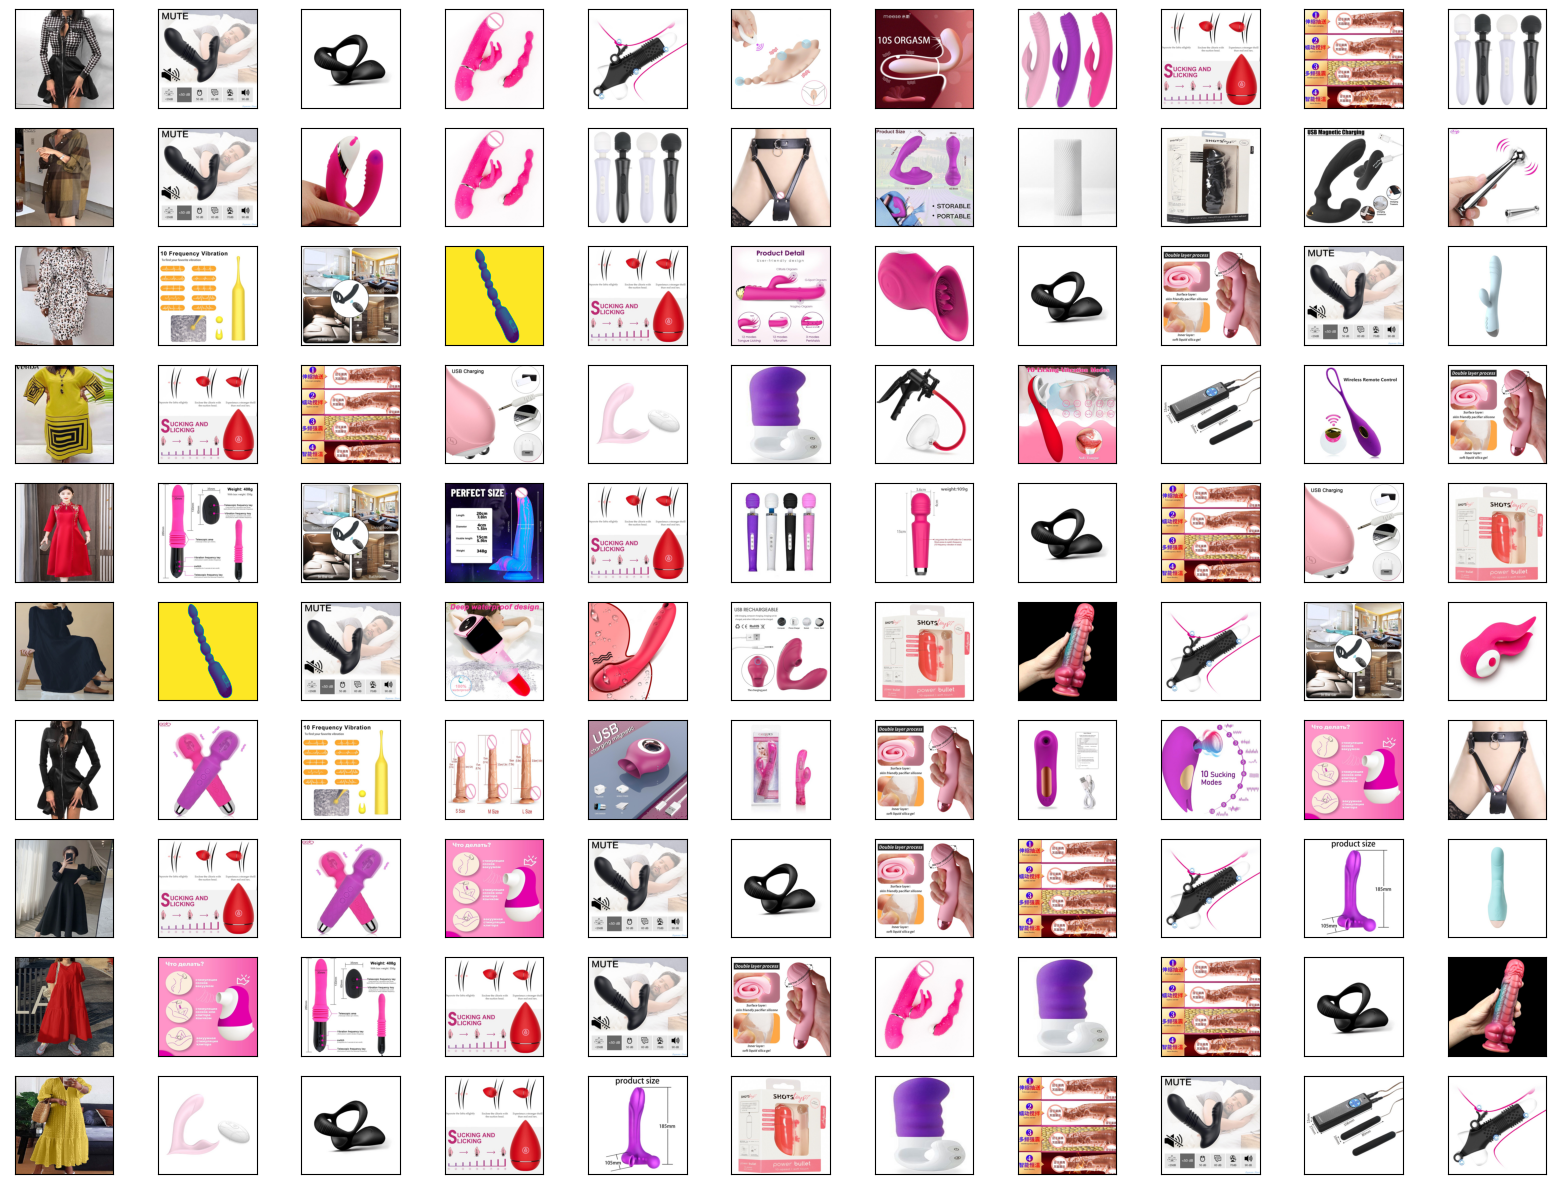

In [17]:
draw_example(
    query_img_paths, 
    doc_img_paths, 
    closest_indices, 
    topk=10, 
    layer='layer3', 
    pooling='max',
    embs_size=256,
    figsize=(16, 12),
)

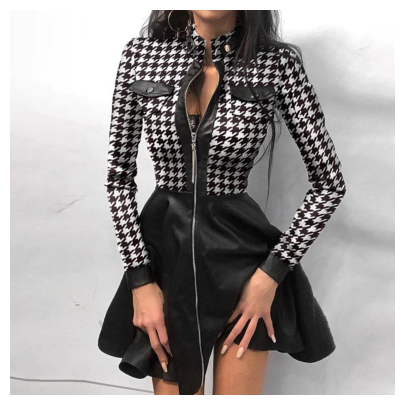

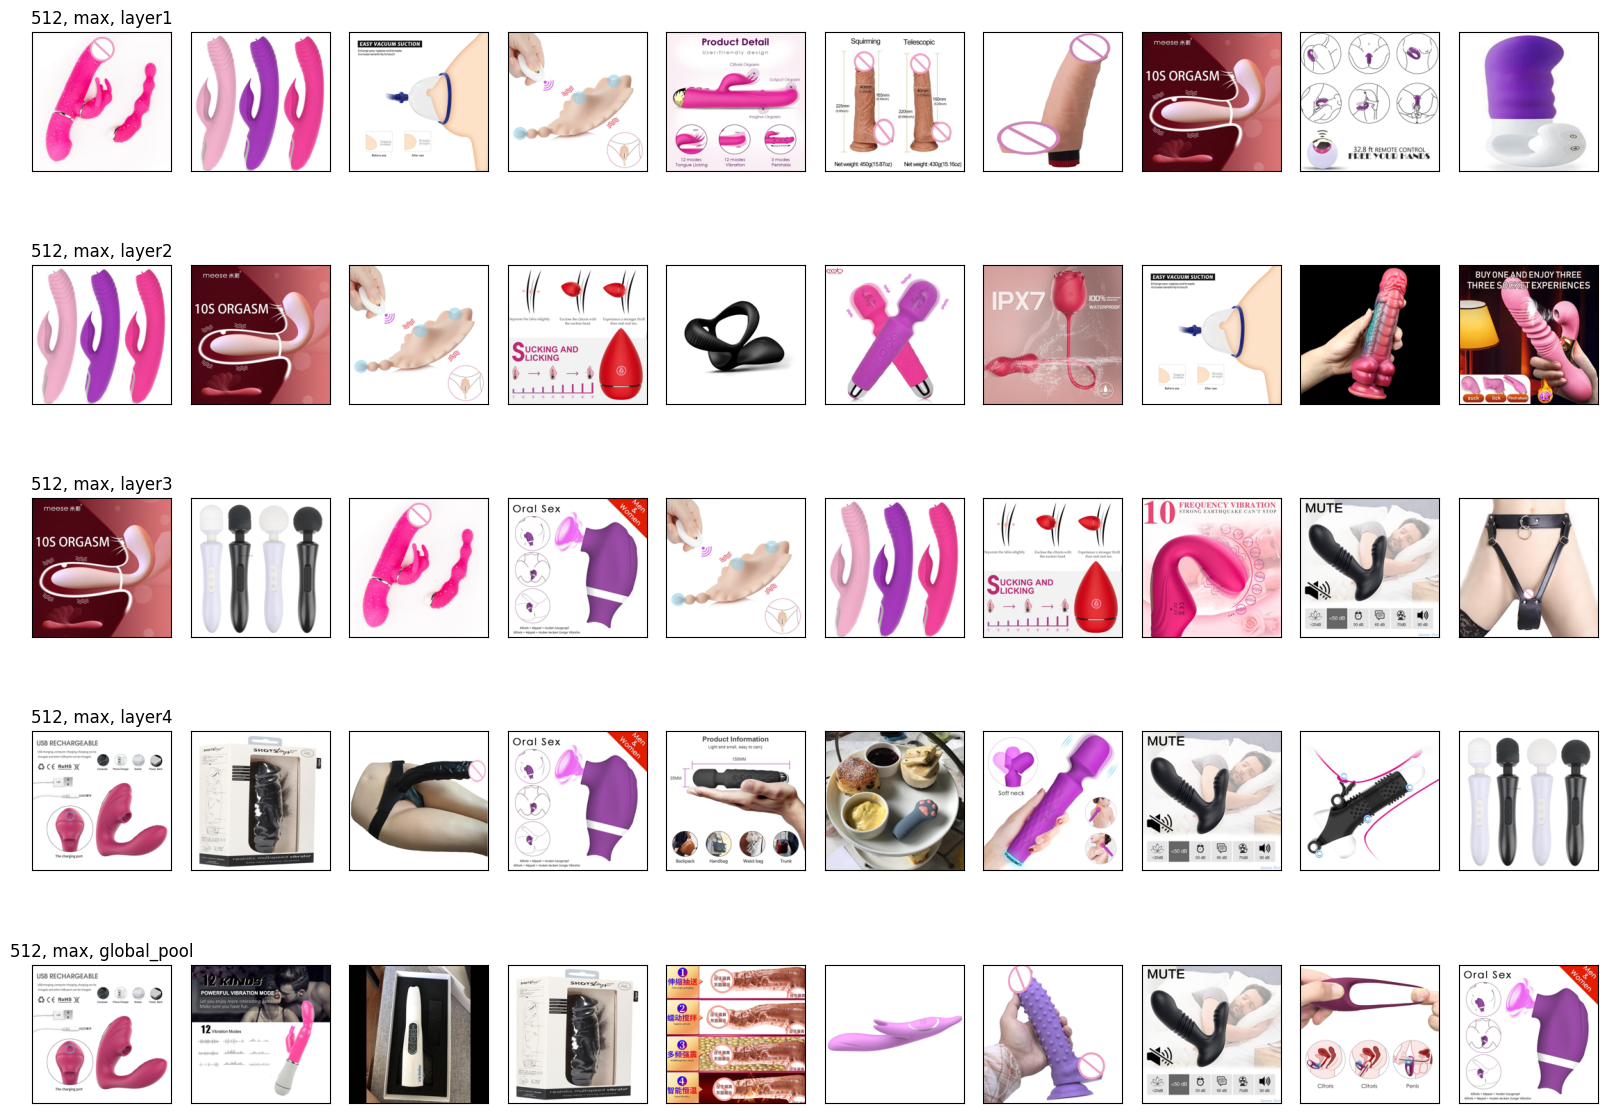

In [18]:
draw_all_layers(
    query_img_path=query_img_paths[0], 
    doc_img_paths=doc_img_paths,
    query_index=0,
    closest_indices=closest_indices,
    topk=10,
    embs_size=512,
    pooling='max',
    figsize=(16, 12)
)   